In [1]:
import os
import requests
import csv
import re
import numpy as np
import pandas as pd
from scipy import stats
import datetime
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

---

In [2]:
def get_stock_data(ticker, seconds_interval, num_of_days):
    
    url = "http://www.google.com/finance/getprices?q={0}&i={1}&p={2}d&f=d,o,h,l,c,v".format(ticker, seconds_interval, num_of_days)

    # get data and convert to data frame
    stock_df = pd.read_csv(url, skiprows=[0,1,2,3,5,6])

    # rename column name
    stock_df.rename(columns={'COLUMNS=DATE':'time'}, inplace=True)

    # remove 'a' from unix timestamps
    stock_df.replace(to_replace={'time':{'a':''}}, regex=True, inplace=True)

    # get entire column and convert to ints
    time_indices = [int(x) for x in stock_df['time'].values]

    # keep track of current timestamp
    last_timestamp = time_indices[0]

    # convert unix timestamp abbreviations into full unix timestamps
    for i in range(len(time_indices)):
        if time_indices[i] < last_timestamp:
            time_indices[i] = last_timestamp + (time_indices[i] * seconds_interval)
        else:
            last_timestamp = time_indices[i]

    # convert unix timestamps to human-readable formats
    time_indices = [datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S') for x in time_indices]
    
    # keep times (i.e., not dates)
    times = [float(x[-8:-3].replace(':','.')) for x in time_indices]

    # create new column in data frame
    stock_df['time'] = times

    # keep day of month
    #dates = [int(x[:10].split('-')[2]) for x in time_indices]
    # create new column in data frame
    #stock_df['month_date'] = dates

    # get weekday as int value
    #stock_df['week_day'] = [datetime.datetime.strptime(x[:10], '%Y-%m-%d').weekday() for x in time_indices]

    # create features
    stock_df['op_cl%'] = np.true_divide((stock_df['CLOSE'] - stock_df['OPEN']), stock_df['CLOSE'])
    stock_df['lo_hi%'] = np.true_divide((stock_df['HIGH'] - stock_df['LOW']), stock_df['HIGH'])
    stock_df['vol_norm'] = np.true_divide(stock_df['VOLUME'], np.max(stock_df['VOLUME']))

    # create labels dataframe
    labels_df = stock_df.copy(deep=True)

    # remove columns
    stock_df = stock_df.drop(['CLOSE', 'OPEN', 'LOW', 'HIGH', 'VOLUME'], axis=1)

    #print stock_df.shape
    #stock_df.head()
    
    return stock_df, labels_df

In [3]:
tickers = [filename[:-4] for filename in os.listdir('quandl_data')]

In [4]:
# download data

remove_tickers = []

for ticker in tickers:
    
    seconds_interval = 1800 # 1800: 30-minute (seems the most consistent)
    try:
        stock_df, labels_df = get_stock_data(ticker, seconds_interval, 1000)
        
        stock_df.to_csv("goog_data/{}_features.csv".format(ticker), index=False)
        labels_df.to_csv("goog_data/{}_labels.csv".format(ticker), index=False)
    except: 
        print "problem with", ticker
        remove_tickers.append(ticker)

problem with IMRS


In [5]:
[tickers.remove(ticker) for ticker in remove_tickers]
print len(tickers), tickers

84 ['ABIO', 'ACOR', 'ADMA', 'AERI', 'AFFX', 'AGEN', 'APPY', 'ARDM', 'ARIA', 'ARNA', 'ARWR', 'ATNM', 'AVXL', 'AXDX', 'AXGN', 'AXN', 'BABY', 'BASI', 'BCLI', 'BCRX', 'BGMD', 'BIIB', 'BLUE', 'BOTA', 'BRKR', 'CBLI', 'CBMG', 'CBMX', 'CBPO', 'CGEN', 'CLDN', 'CLDX', 'CNMD', 'COHR', 'CPHD', 'CPRX', 'CRIS', 'CUTR', 'CYBX', 'CYNO', 'CYTR', 'DARA', 'DRAD', 'DSCO', 'DYAX', 'ECTE', 'ECYT', 'ELOS', 'ENZN', 'ESMC', 'ETRM', 'EXAS', 'EXEL', 'FATE', 'FEIC', 'FLDM', 'FONR', 'GEVA', 'GILD', 'GNCA', 'HALO', 'HSKA', 'IART', 'ICCC', 'IDRA', 'IDXX', 'ILMN', 'IMMU', 'INCY', 'INO', 'IRIX', 'LPCN', 'MEIP', 'MNKD', 'OREX', 'PGNX', 'QLTI', 'RMTI', 'SGYP', 'SNGX', 'SYN', 'THLD', 'TNXP', 'TPIV']


In [6]:
# import data

X = []
y = []

pred_X = []

for ticker in tickers:

    stock_df = pd.read_csv("goog_data/{}_features.csv".format(ticker))
    labels_df = pd.read_csv("goog_data/{}_labels.csv".format(ticker))
    
    if ticker == tickers[0]:
        print stock_df.head()
        print stock_df.tail()

    num_of_times = stock_df['time'].unique().shape[0]
    stock_df = stock_df.drop('time', axis=1)
    assert num_of_times == 14, "wrong number of times, got {0} for {1}".format(num_of_times, ticker)
    #print "number of times in a day: {}".format(num_of_times)

    num_of_days = stock_df.shape[0]/num_of_times
    #print "number of days: {}".format(num_of_days)

    for i in xrange(num_of_days):

        # features
        features = stock_df.values[:num_of_times].flatten()
        features = np.expand_dims(features, axis=0)
        #assert features.shape[1] == 84, "wrong number of columns"

        # combine features into rows of X
        if X == []:
            X = features
        else: 
            X = np.vstack((X, features))

        # labels
        labels = labels_df.values[:num_of_times].flatten()
        # (last - open) / last
        label = np.true_divide((labels[-8] - labels[1]), labels[-8])
        # make class
        label = int(label*100)
        
        # make binary class
        def binarize(label):
            if label >= 5.0:
                label = 1
            else:
                label = 0
            return label
        
        label = binarize(label)

        if y == []:
            y = np.array([label])
        else:
            y = np.append(y, np.array(label))  

        # remove used rows (go to next day)
        stock_df = stock_df[num_of_times:]
        labels_df = labels_df[num_of_times:]

    # keep last for prediction
    if pred_X == []:
        pred_X = X[-1:]
    else: 
        pred_X = np.vstack((pred_X, X[-1:]))

    # rotate/discard rows
    X = X[:-1]
    y = y[1:]

print "\n", "*"*10, "\nfinal shapes: ", X.shape, y.shape, pred_X.shape

   time    op_cl%    lo_hi%  vol_norm
0   9.3  0.000000  0.000000  0.000097
1  10.0 -0.010707  0.010594  0.001126
2  10.3 -0.011683  0.011548  0.002789
3  11.0 -0.011806  0.011786  0.004092
4  11.3 -0.000120  0.000120  0.000307
     time    op_cl%    lo_hi%  vol_norm
689  14.0  0.005444  0.032609  0.005680
690  14.3  0.032258  0.032258  0.000205
691  15.0 -0.044944  0.043011  0.002278
692  15.3  0.032609  0.032609  0.000711
693  16.0  0.000000  0.018261  0.000768

********** 
final shapes:  (3781, 42) (3781,) (84, 42)


---

In [7]:
np.round(X[0], 5)

array([ 0.     ,  0.     ,  0.0001 , -0.01071,  0.01059,  0.00113,
       -0.01168,  0.01155,  0.00279, -0.01181,  0.01179,  0.00409,
       -0.00012,  0.00012,  0.00031,  0.01179,  0.01179,  0.0002 ,
        0.00774,  0.01119,  0.00205,  0.00129,  0.02106,  0.00513,
       -0.02348,  0.02294,  0.00041, -0.02348,  0.02294,  0.00517,
        0.     ,  0.     ,  0.00052,  0.00905,  0.02294,  0.00624,
       -0.01144,  0.0119 ,  0.00399,  0.     ,  0.     ,  0.00125])

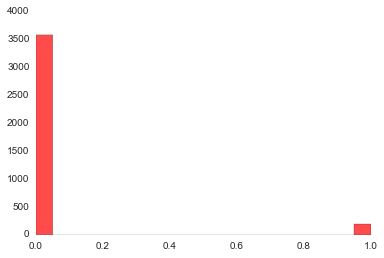

In [8]:
plt.hist(y, bins=20, alpha=0.7, color='r')
plt.show()

In [9]:
pred_X[0]

array([-0.02109515,  0.02197802,  0.00506599,  0.01654898,  0.03130435,
        0.00184934,  0.        ,  0.00380435,  0.00030703,  0.        ,
        0.        ,  0.00030703, -0.00645444,  0.0101087 ,  0.00153515,
        0.01086957,  0.02173913,  0.00639646, -0.00010871,  0.01086957,
        0.00080135, -0.01087912,  0.04413043,  0.01955115,  0.        ,
        0.        ,  0.01023433,  0.03225806,  0.04255319,  0.00301913,
       -0.04409641,  0.0516333 ,  0.0199375 ,  0.00299036,  0.05242105,
        0.00234571,  0.01119035,  0.01119035,  0.0007164 , -0.01111111,
        0.01098901,  0.00830516])

---

In [10]:
def add_bias(matrix):
    if matrix.ndim == 1:
        matrix = matrix.reshape(matrix.shape[0], 1)
    return np.hstack((np.ones((matrix.shape[0], 1)), matrix))

In [11]:
def g(z):
    return np.true_divide(1, (1+np.exp(-z)))

In [12]:
def g_prime(z):
    return np.multiply(z, (1 - z))

In [13]:
def J(m, L, s, thetas, predictions, y, lambda_reg):
    J_sum = 0
    for i in xrange(m):
        J_sum += y[i] * np.log(predictions[i]) + (1 - y[i]) * np.log(1 - predictions[i])
        
    left_side = np.true_divide(J_sum, -m)
    
    theta_sums = 0
    for l in xrange(L-1):
        # s_j
        for i in xrange(s[l]):
            # s_jplus1
            for j in xrange(s[l+1]):
                # (skip bias term)
                theta_sums += thetas[l][:,1:][j][i]**2
                
    right_side = np.true_divide(lambda_reg, 2.0*m) * theta_sums
    
    return left_side + right_side

lambda_reg = 100
#J(m, L, s, thetas, predictions, y, lambda_reg)

In [14]:
def create_thetas(L, s):
    init_seed_value = 42
    thetas = []
    for l in xrange(L-1):
        np.random.seed(init_seed_value+1)
        s_j = s[l]
        s_jplus1 = s[l+1]
        theta = np.random.standard_normal((s_jplus1,s_j+1))
        thetas.append(theta)
        
    return thetas

In [15]:
X = add_bias(X)

In [17]:
n = X.shape[1]-1
# number of layers
L = 4
# number of units in each layer
s = [n, n, n, 1]
thetas = create_thetas(L, s)
[theta.shape for theta in thetas]

[(42, 43), (42, 43), (1, 43)]

In [31]:
def forward_propagation(a1, thetas):
    a2 = g(a1.dot(thetas[0].T))
    a2 = add_bias(a2)
    z2 = a2.dot(thetas[1].T)
    
    a3 = g(z2)
    a3 = add_bias(a3)
    z3 = a3.dot(thetas[2].T)
    
    a4 = g(z3)
    
    return a2, z2, a3, z3, a4

In [41]:
def back_propagation(m, X, thetas, y, lambda_reg):
    predictions = []
    
    layers = []
    
    Delta2 = []
    Delta3 = []
    for i in xrange(m):
        a1 = X[i,:].reshape(1,n+1)
        a2, z2, a3, z3, a4 = forward_propagation(a1, thetas)
        
        predictions.append(a4)
    
        d4 = a4 - y[i]
        
        d3 = np.multiply(thetas[2].T.dot(d4), g_prime(z3))
        d2 = np.multiply(thetas[1].dot(d3), g_prime(z2))
    
        if Delta2 == []:
            Delta2 = (d3 * a2.T)
        else:
            Delta2 = Delta2 + (d3 * a2.T)
            
        if Delta3 == []:
            Delta3 = (d4 * a3.T)
        else:
            Delta3 = Delta3 + (d4 * a3.T)
        
    D2 = np.true_divide(Delta2, m)
    D3 = np.true_divide(Delta3, m)
    
    # (skip bias term for regularization)
    #D2[:,1:] = D2[:,1:] + (lambda_reg * thetas[1][:,1:])
                
    return D2, D3, predictions

#back_propagation(m, X, thetas, predictions, y, lambda_reg)

0
10
20
30
40


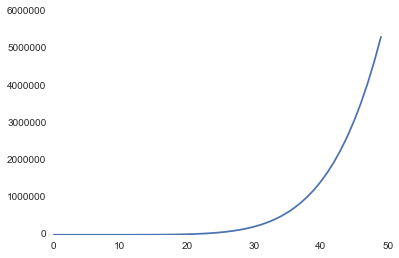

In [46]:
m = X.shape[0]

thetas = create_thetas(L, s)
#print [theta.shape for theta in thetas]

costs = []
alpha = -0.3
iterations = 50

# gradient descent
for i in xrange(iterations):
    if i % 10 == 0:
        print i

    D2, D3, predictions = back_propagation(m, X, thetas, y, lambda_reg)
    
    cost = J(m, L, s, thetas, predictions, y, lambda_reg)
    costs.append(cost[0])

    thetas[1] = np.subtract(thetas[1], np.multiply(alpha, D2).T)
    thetas[2] = np.subtract(thetas[2], np.multiply(alpha, D3).T)

plt.plot([x for x in xrange(iterations)], costs)
plt.show()

---

In [20]:
print [theta.shape for theta in thetas]
thetas

[(42, 43), (1, 43)]


[array([[ 0.25739993, -0.90848143, -0.37850311, ...,  1.22121596,
          1.01498852,  0.82812998],
        [ 2.26629271, -0.59495567, -0.58126954, ...,  0.17979165,
          1.51644162, -1.63403202],
        [ 1.7819709 , -0.6177277 , -1.08639929, ...,  1.77318123,
         -0.44662929,  1.48937458],
        ..., 
        [ 1.33135503,  0.2862364 ,  1.94424814, ...,  0.61458671,
          1.48022868,  1.45106538],
        [ 2.74556654, -1.08520701,  0.78197623, ..., -0.08504605,
         -0.65795505,  0.01198371],
        [ 0.85963477, -0.2912263 , -0.05077664, ...,  0.30135887,
          0.77119717,  0.24499227]]),
 array([[-0.11200559, -1.10711303, -0.69952667, -0.84485495,  0.55601905,
         -0.68426512,  0.4366963 ,  1.8791015 ,  0.98703586, -0.72979725,
         -0.5278974 ,  0.27861152, -1.95997618, -0.934419  ,  0.4635056 ,
         -0.21157583,  1.81914057, -0.83829337, -1.20505664, -1.02699131,
         -0.18207779, -0.25026761,  1.93776707, -0.72658554, -0.2342478 ,
  

In [21]:
pred_X = add_bias(pred_X)
pred_X[0]

array([  1.00000000e+00,  -2.10951526e-02,   2.19780220e-02,
         5.06599352e-03,   1.65489850e-02,   3.13043478e-02,
         1.84934349e-03,   0.00000000e+00,   3.80434783e-03,
         3.07029910e-04,   0.00000000e+00,   0.00000000e+00,
         3.07029910e-04,  -6.45443606e-03,   1.01086957e-02,
         1.53514955e-03,   1.08695652e-02,   2.17391304e-02,
         6.39645647e-03,  -1.08707468e-04,   1.08695652e-02,
         8.01348066e-04,  -1.08791209e-02,   4.41304348e-02,
         1.95511530e-02,   0.00000000e+00,   0.00000000e+00,
         1.02343303e-02,   3.22580645e-02,   4.25531915e-02,
         3.01912745e-03,  -4.40964123e-02,   5.16332982e-02,
         1.99374989e-02,   2.99036438e-03,   5.24210526e-02,
         2.34570852e-03,   1.11903456e-02,   1.11903456e-02,
         7.16403124e-04,  -1.11111111e-02,   1.09890110e-02,
         8.30515907e-03])

In [22]:
for i in xrange(pred_X.shape[0]):
    a1 = X[i,:].reshape(1,n+1)
    a2, a3 = forward_propagation(a1, thetas)
    print str(i).rjust(2), str(tickers[i]).rjust(4), np.round(a3[0][0], 2)

 0 ABIO 0.04
 1 ACOR 0.04
 2 ADMA 0.05
 3 AERI 0.04
 4 AFFX 0.05
 5 AGEN 0.05
 6 APPY 0.04
 7 ARDM 0.05
 8 ARIA 0.04
 9 ARNA 0.05
10 ARWR 0.05
11 ATNM 0.15
12 AVXL 0.05
13 AXDX 0.05
14 AXGN 0.04
15  AXN 0.05
16 BABY 0.05
17 BASI 0.04
18 BCLI 0.05
19 BCRX 0.05
20 BGMD 0.04
21 BIIB 0.04
22 BLUE 0.04
23 BOTA 0.05
24 BRKR 0.04
25 CBLI 0.05
26 CBMG 0.05
27 CBMX 0.05
28 CBPO 0.05
29 CGEN 0.05
30 CLDN 0.05
31 CLDX 0.05
32 CNMD 0.04
33 COHR 0.04
34 CPHD 0.04
35 CPRX 0.04
36 CRIS 0.04
37 CUTR 0.04
38 CYBX 0.04
39 CYNO 0.05
40 CYTR 0.06
41 DARA 0.05
42 DRAD 0.05
43 DSCO 0.05
44 DYAX 0.05
45 ECTE 0.06
46 ECYT 0.05
47 ELOS 0.04
48 ENZN 0.06
49 ESMC 0.07
50 ETRM 0.07
51 EXAS 0.04
52 EXEL 0.06
53 FATE 0.07
54 FEIC 0.13
55 FLDM 0.03
56 FONR 0.11
57 GEVA 0.06
58 GILD 0.09
59 GNCA 0.07
60 HALO 0.05
61 HSKA 0.11
62 IART 0.11
63 ICCC 0.13
64 IDRA 0.06
65 IDXX 0.03
66 ILMN 0.04
67 IMMU 0.03
68 INCY 0.03
69  INO 0.04
70 IRIX 0.04
71 LPCN 0.04
72 MEIP 0.03
73 MNKD 0.04
74 OREX 0.04
75 PGNX 0.04
76 QLTI 0.05

In [ ]:
positive_tickers = []
for i in xrange(len(pred_tickers)):
    print i, pred_tickers[i], y_predictions[i]
    if y_predictions[i] == 1:
        positive_tickers.append(pred_tickers[i])

In [ ]:
for ticker in positive_tickers:
    
    past_days = 100
    
    oc = prediction_df[prediction_df['ticker'] == ticker]["OC%"][-past_days:]
    
    num_days = oc.shape[0]
    
    day_range = np.arange(num_days)
    
    plt.plot(day_range, oc, alpha=0.5)
    plt.plot(day_range, [0.05 for x in day_range], color='r')
    plt.title("{0} (previous {1} days)".format(ticker, num_days))
    plt.show()

    print "\t", ticker, "{}-day freq probability:".format(past_days), np.true_divide(np.sum(oc.values > 0.05), past_days)
    print "~"*50, "\n"  

In [ ]:
#errors = []
iterations = 1

for i in xrange(iterations):

    
#plt.plot([x for x in xrange(iterations)], errors)
#plt.show()

In [36]:
X = np.array([[1,2,3,4],
              [1,3,4,5],
              [1,6,7,8],
              [1,5,4,3],
              [1,2,3,3]])
print X.shape

theta1 = np.array([[2,2,3,4],
                   [4,3,4,5],
                   [6,6,7,8]])

print theta1.T
print theta1.shape

print X.dot(theta1.T)
print X.dot(theta1.T).shape

(5, 4)
[[2 4 6]
 [2 3 6]
 [3 4 7]
 [4 5 8]]
(3, 4)
[[ 31  42  71]
 [ 40  54  92]
 [ 67  90 155]
 [ 36  50  88]
 [ 27  37  63]]
(5, 3)
